In [1]:
import pandas as pd
import numpy as np
from functools import reduce
from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

from scipy.stats import entropy
entropy_fix = np.log2(np.e)

In [2]:
def running_mean(x, N=5):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [3]:
month_table = pd.read_csv('MORI-month_table.csv', index_col=0)

month_table.head()

,AG,AID,AW,BF,BSE,Coa,Com,Cou,Cri,DK,...,SA,SWA,TU,Tax,Tra,Tsu,Une,month,year,date
29,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,10.0,0.0,...,0.0,0.0,26.0,0.0,0.0,0.0,82.0,Jan-85,1985.0,1985-01-01
30,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,8.0,0.0,...,0.0,0.0,26.0,0.0,0.0,0.0,79.0,Feb-85,1985.0,1985-02-01
31,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,13.0,0.0,...,0.0,0.0,7.0,0.0,0.0,0.0,85.0,Mar-85,1985.0,1985-03-01
32,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,12.0,0.0,...,0.0,0.0,9.0,0.0,0.0,0.0,85.0,Apr-85,1985.0,1985-04-01
33,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,15.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,85.0,May-85,1985.0,1985-05-01


In [5]:
# make the moving average month table
N = 5

new_df_dic = {}
for key in month_table.keys()[:-3]:
    new_df_dic[key] = running_mean(month_table[key].values, N=N)

new_df_dic['month'] = month_table['month'].values[int((N-1)/2):-int((N-1)/2)]
new_df_dic['year']  = month_table['year'].values[int((N-1)/2):-int((N-1)/2)]

table_moving_average = pd.DataFrame(new_df_dic)
table_moving_average.head()

,AG,AID,AW,BF,BSE,Coa,Com,Cou,Cri,DK,...,Rac,SA,SWA,TU,Tax,Tra,Tsu,Une,month,year
0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,11.6,0.0,...,2.8,0.0,0.0,14.6,0.0,0.0,0.0,83.2,Mar-85,1985.0
1,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,13.6,0.0,...,3.6,0.0,0.0,10.4,0.0,0.0,0.0,82.4,Apr-85,1985.0
2,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,15.4,0.0,...,3.2,0.0,0.0,6.2,0.0,0.0,0.0,82.6,May-85,1985.0
3,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,16.0,0.0,...,3.8,0.0,0.0,5.6,0.0,0.0,0.0,82.2,Jun-85,1985.0
4,0.0,0.0,0.0,0.0,0.0,0.0,2.8,0.0,17.4,0.0,...,5.4,0.0,0.0,4.4,0.0,0.0,0.0,81.8,Jul-85,1985.0


In [6]:
table = table_moving_average

all_entropies = []
n_issues = []

for index, row in table.iterrows():
    topic_array = np.array(row.values[:-2],dtype=np.float64)
    all_entropies += [ entropy(topic_array)*entropy_fix ]
    n_issues      += [ sum(row.values[:-2]>0) ]

all_entropies = np.array(all_entropies)
n_issues      = np.array(n_issues)

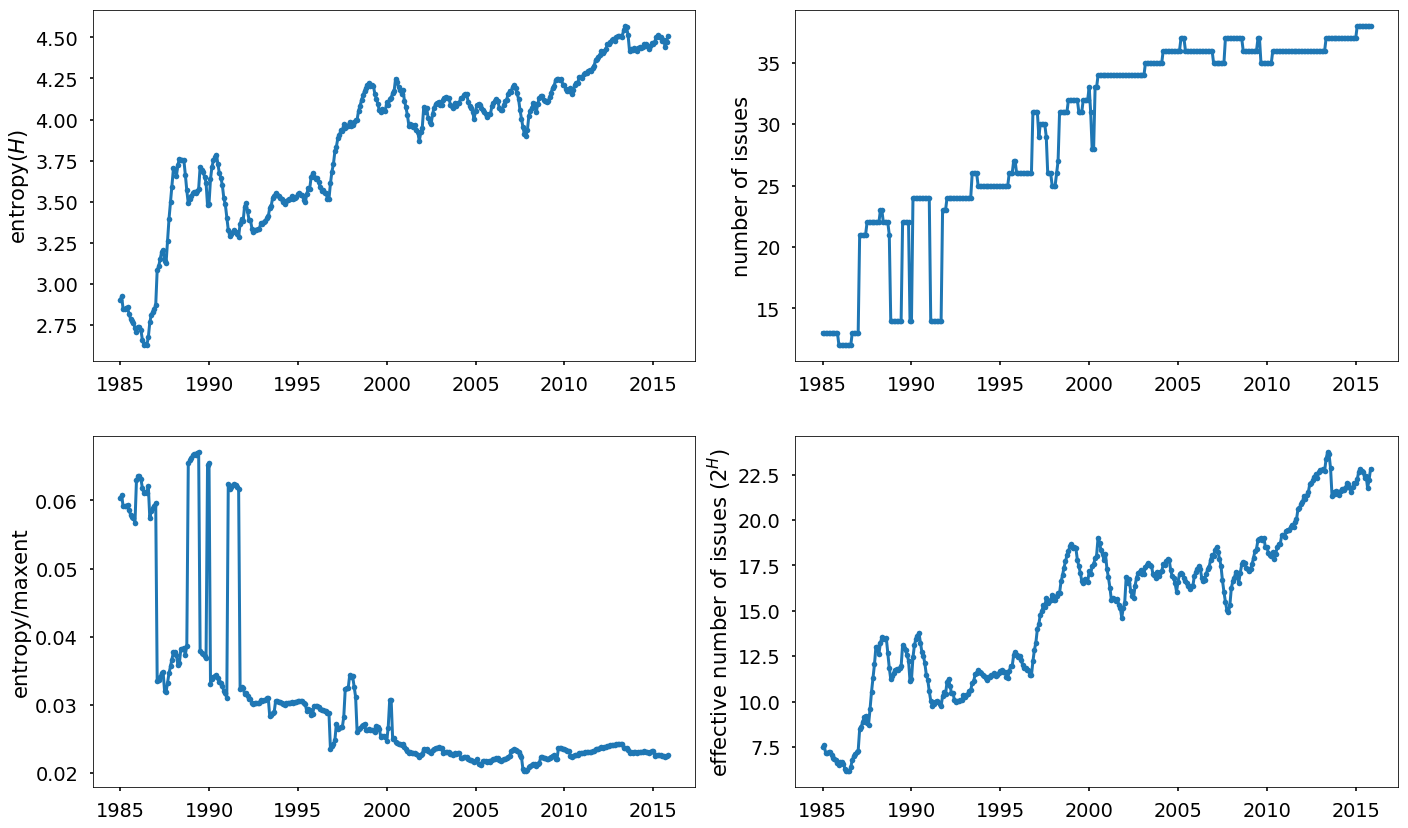

In [6]:
sns.set_context('poster', rc={"lines.linewidth": 3}, font_scale=1.2)

fig, axs = plt.subplots(2,2,figsize=(20,12))
axs = [ axs[0,0], axs[0,1], axs[1,0], axs[1,1] ]

ys = [ [ s                if n>0 else -np.inf for s,n in zip(all_entropies, n_issues) ],
       [ n                if n>0 else -np.inf for s,n in zip(all_entropies, n_issues) ],
       [ s/(n*np.log2(n)) if n>0 else -np.inf for s,n in zip(all_entropies, n_issues) ],
       [ 2**s             if n>0 else -np.inf for s,n in zip(all_entropies, n_issues) ]
     ]


xticks = np.arange(0,35*12,5*12)
xticklabels = [ str(i) for i in np.arange(1985,2020,5) ]

ylabels = ['entropy($H$)', 'number of issues', 'entropy/maxent', r'effective number of issues ($2^H$)']
for ax,y,ylabel in zip(axs,ys,ylabels):
    ax.plot(table.index, y, '.-')
    ax.set_ylabel(ylabel)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    
plt.tight_layout()
plt.savefig('images/entropy-months.png', dpi=200)
plt.show()

In [7]:
from numpy.linalg import norm
from scipy.spatial.distance import hamming
from scipy.spatial.distance import euclidean
from sklearn.metrics import mutual_info_score

def rel_entr(p, q, ep=0.01, fill_all_zeros=True):
    if fill_all_zeros is True:
        P = [ i if i > 0 else ep for i in p ]
        Q = [ i if i > 0 else ep for i in q ]
        return entropy(P,Q)*entropy_fix
    
    else:
        P = []
        Q = []
        for i in range(len(p)):
            
            if p[i] == 0:
                if q[i] != 0:
                    P += [ep]
                    Q += [q[i]]
                else: # q[i] == 0
                    P += [p[i]]
                    Q += [q[i]]
                    continue
                    
            else:# p[i] != 0
                if q[i] != 0:
                    P += [p[i]]
                    Q += [q[i]]
                else: # q[i] == 0
                    P += [p[i]]
                    Q += [ep]
                    
        return entropy(P,Q)*entropy_fix


def JSD(P, Q,ep=0.01, fill_all_zeros=True):
    _P = P / norm(P, ord=1)
    _Q = Q / norm(Q, ord=1)
    _M = 0.5 * (_P + _Q)
    return 0.5 * (rel_entr(_P, _M,ep=ep,fill_all_zeros=fill_all_zeros) + rel_entr(_Q, _M,ep=ep,fill_all_zeros=fill_all_zeros))


def BCD(P,Q):
    _P = np.array(P / norm(P, ord=1),dtype=np.float32)
    _Q = np.array(Q / norm(Q, ord=1),dtype=np.float32)
    BC = np.dot(np.sqrt(_P),np.sqrt(_Q))
    
    return -np.log2(BC)    


def MI(_P,_Q):
    return mutual_info_score(_P,_Q)


def novelty(p,q,metric='KL', ep=0.01, faz=True):
    
    if metric=='KL':
        return rel_entr(p,q,ep=ep,fill_all_zeros=faz)
    elif metric=='hamming':
        return hamming(p>0,q>0)
    elif metric=='euclidean':
        return euclidean(p,q)
    elif metric=='JSD':
        return JSD(p,q,ep=ep,fill_all_zeros=faz)
    elif metric=='BCD':
        return BCD(p,q)
    elif metric=='MI':
        return MI(p,q)
    else:
        return 0

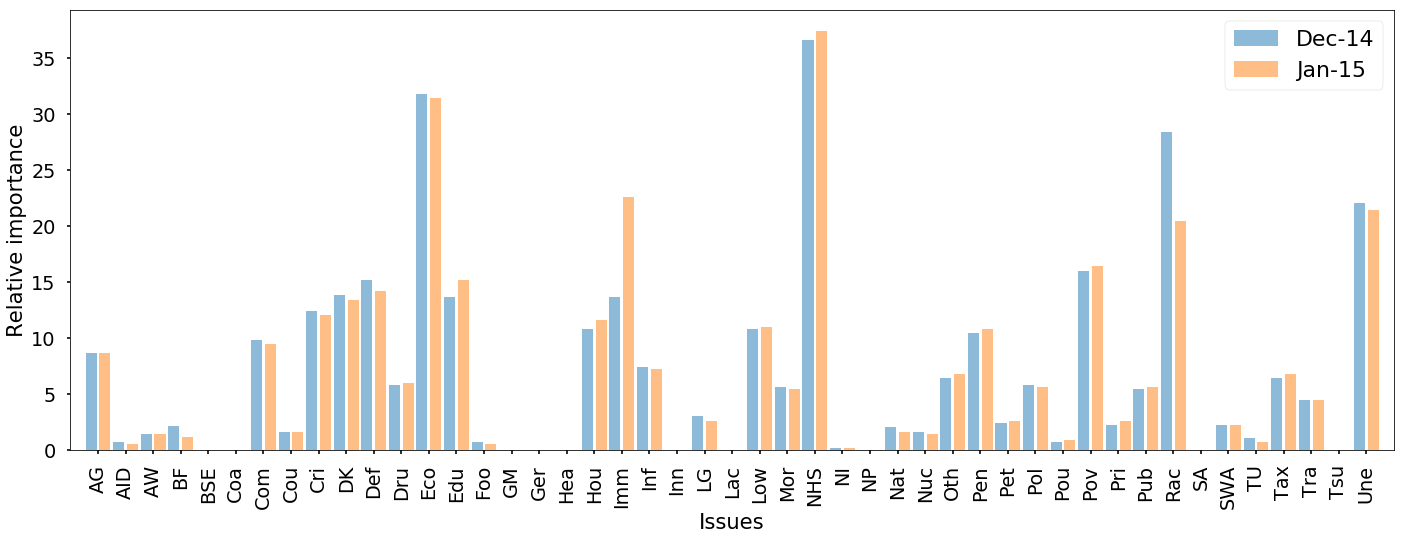

In [8]:
table = table_moving_average
keys = table.keys()[:-2]

i1 = 341
i2 = 342

y1 = np.array(table.iloc[i1].values[:-2],dtype=np.float64)
y2 = np.array(table.iloc[i2].values[:-2],dtype=np.float64)

fig, ax = plt.subplots(1, figsize=(20,8))

x = np.arange(len(keys))
ax.bar(2*x-1, y1, alpha=0.5, label=str(table.loc[i1].month))
ax.bar(2*x,   y2, alpha=0.5, label=str(table.loc[i2].month))

ax.set_xticks(2*x-0.5)
ax.set_xticklabels(keys, rotation=90)
ax.set_xlim(-2.5,2*len(x)-0.5)
ax.set_xlabel('Issues')
ax.set_ylabel('Relative importance')

plt.legend(fontsize=22)
plt.tight_layout()
plt.savefig('images/MII-two-months.png', dpi=200)
plt.show()

## 1 - Make entropy plots

In [9]:
table = table_moving_average
issues_tplus1 = table[table.index>table.index[0]]

eps = [0.001, 0.01, 0.1, 0.2]
KLs_faz_True = {}
KLs_faz_False = {}
hammings = {}
JSDs = {}
BCDs = {}
MIs = {}

for ep in eps:
    relative_entropies_True = []
    relative_entropies_False = []
    relative_entropies_hamm = []
    jensen = []
    bhatta = []
    mutual = []
    
    row = table.iloc[0]
    previous_topic_array = np.array(row.values[:-2])
   
    for index, row in issues_tplus1.iterrows():
        topic_array = np.array(row.values[:-2])
        y1 = previous_topic_array
        y2 = topic_array
        relative_entropies_True  += [ novelty(y2, y1, metric='KL', ep=ep, faz=True) ]
        relative_entropies_False += [ novelty(y2, y1, metric='KL', ep=ep, faz=False) ]
        relative_entropies_hamm  += [ novelty(y2, y1, metric='hamming') ]
        jensen += [ novelty(y2, y1, metric='JSD', ep=ep, faz=False) ]
        bhatta += [ novelty(y2, y1, metric='BCD') ]
        mutual += [ novelty(y2, y1, metric='MI')/novelty(y1, y1, metric='MI') ]
        previous_topic_array = topic_array

    KLs_faz_True[ep]  = relative_entropies_True
    KLs_faz_False[ep] = relative_entropies_False
    hammings[ep]      = relative_entropies_hamm
    JSDs[ep]          = jensen
    BCDs[ep]          = bhatta
    MIs[ep]           = mutual

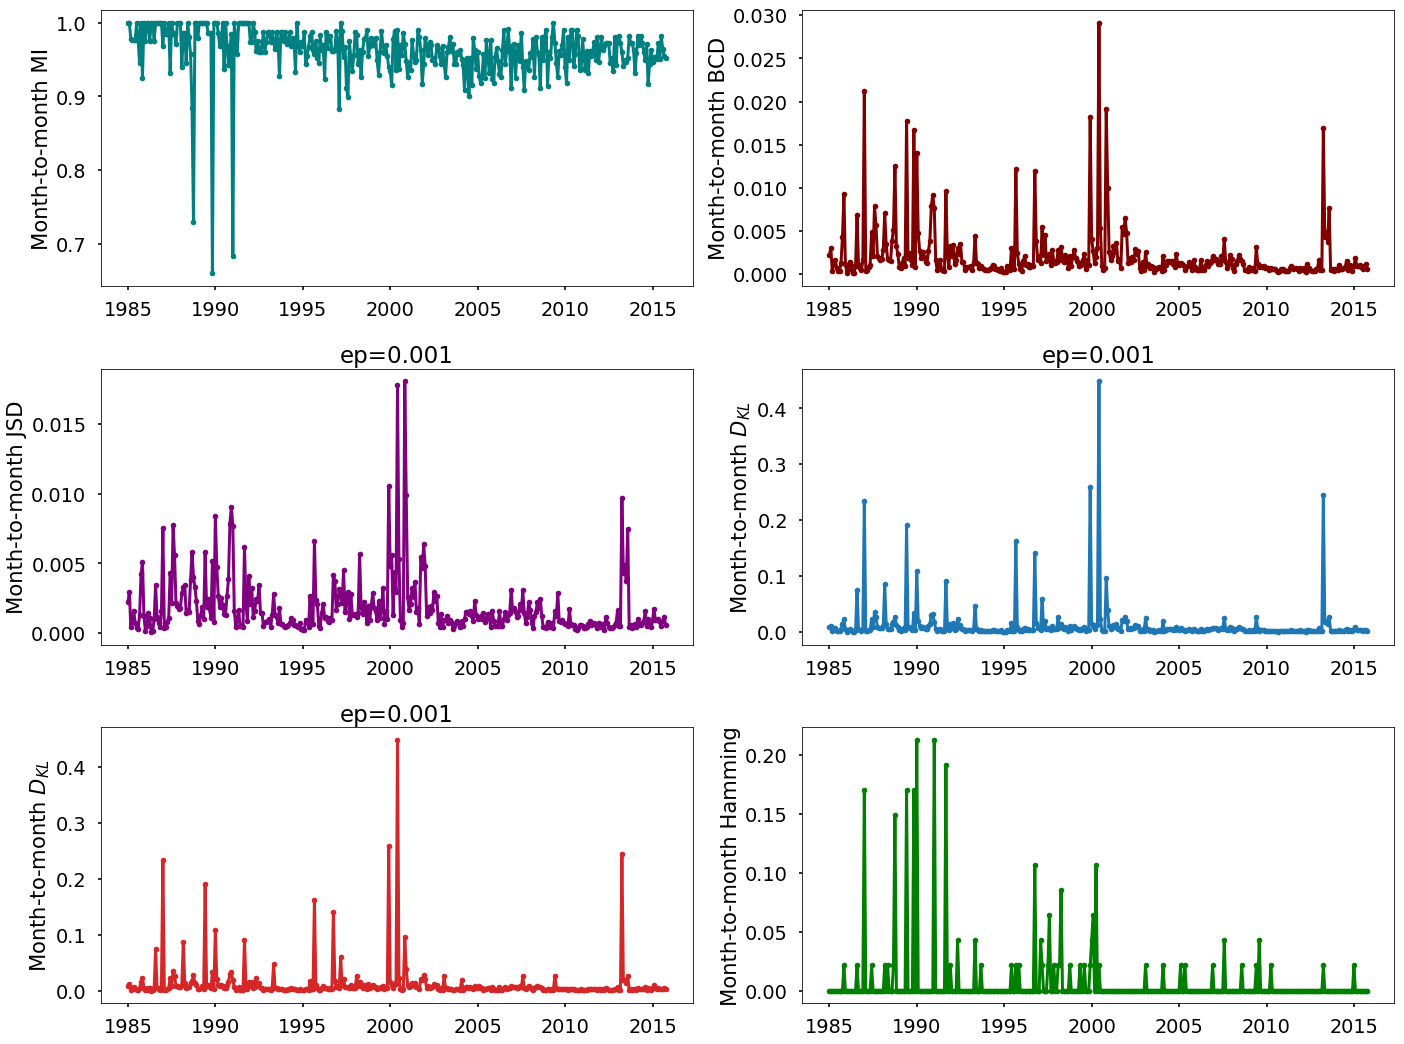

In [10]:
fig, axs = plt.subplots(3,2, figsize=(20,15))

windowsize = 1
axs = axs.reshape((axs.size,))
xticks = np.arange(windowsize,35*12,5*12)
xticklabels = [ str(i) for i in np.arange(1985,2020,5) ]
indices = table.index[windowsize:]

ep = 0.001

# Normalised mutual Information
ax = axs[0]
ax.plot(indices, MIs[ep], '.-', c='teal')
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_ylabel(r'Month-to-month MI')

# Bhattacharya distance
ax = axs[1]
ax.plot(indices, BCDs[ep], '.-', c='maroon')
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_ylabel(r'Month-to-month BCD')

# JSDs:
ax = axs[2]
ax.plot(indices, JSDs[ep], '.-', c='purple')
ax.set_title('ep='+str(ep))
ax.set_ylabel(r'Month-to-month JSD')
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
#ax.set_ylim(-0.1,2.5)
    
# Fill all zeros = False:
ax = axs[3]
ax.plot(indices, KLs_faz_False[ep], '.-')
ax.set_title('ep='+str(ep))
ax.set_ylabel(r'Month-to-month $D_{KL}$')
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
#ax.set_ylim(-0.1,7)

# Fill all zeros = True:
ax = axs[4]
ax.plot(indices, KLs_faz_True[ep], '.-', c='#d62728')
ax.set_title('ep='+str(ep))
ax.set_ylabel(r'Month-to-month $D_{KL}$')
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

# Hamming distance
ax = axs[5]
ax.plot(indices, hammings[ep], '.-', c='g')
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_ylabel(r'Month-to-month Hamming')

plt.tight_layout()
plt.savefig('images/divergence-month-to-month.png', dpi=300)
plt.show()

## Month-to-year comparison
Let's get the divergence metrics between a distribution and the last 12 months.

In [11]:
table = table_moving_average

windowsize = 12
issues_tplus1 = table[table.index>=table.index[windowsize]]
eps = [0.001, 0.01, 0.1, 0.2]
KLs_faz_True = {}
KLs_faz_False = {}
hammings = {}
JSDs = {}
BCDs = {}
MIs = {}

for ep in eps:
    relative_entropies_True = []
    relative_entropies_False = []
    relative_entropies_hamm = []
    jensen = []
    bhatta = []
    mutual = []
    
    row = table.iloc[0]
    #previous_topic_array = np.array(row.values[:-2])
   
    for index, row in issues_tplus1.iterrows():
        #topic_array = np.array(row.values[:-2])
        
        y1 = table.loc[index-12:index-1, ~table.columns.isin(['month','year'])].mean().values
        y2 = np.array(row.values[:-2])
        
        relative_entropies_True  += [ novelty(y2, y1, metric='KL', ep=ep, faz=True) ]
        relative_entropies_False += [ novelty(y2, y1, metric='KL', ep=ep, faz=False) ]
        relative_entropies_hamm  += [ novelty(y2, y1, metric='hamming') ]
        jensen += [ novelty(y2, y1, metric='JSD', ep=ep, faz=False) ]
        bhatta += [ novelty(y2, y1, metric='BCD') ]
        mutual += [ novelty(y2, y1, metric='MI')/novelty(y1, y1, metric='MI') ]
        #previous_topic_array = topic_array

    KLs_faz_True[ep]  = relative_entropies_True
    KLs_faz_False[ep] = relative_entropies_False
    hammings[ep]      = relative_entropies_hamm
    JSDs[ep]          = jensen
    BCDs[ep]          = bhatta
    MIs[ep]           = mutual

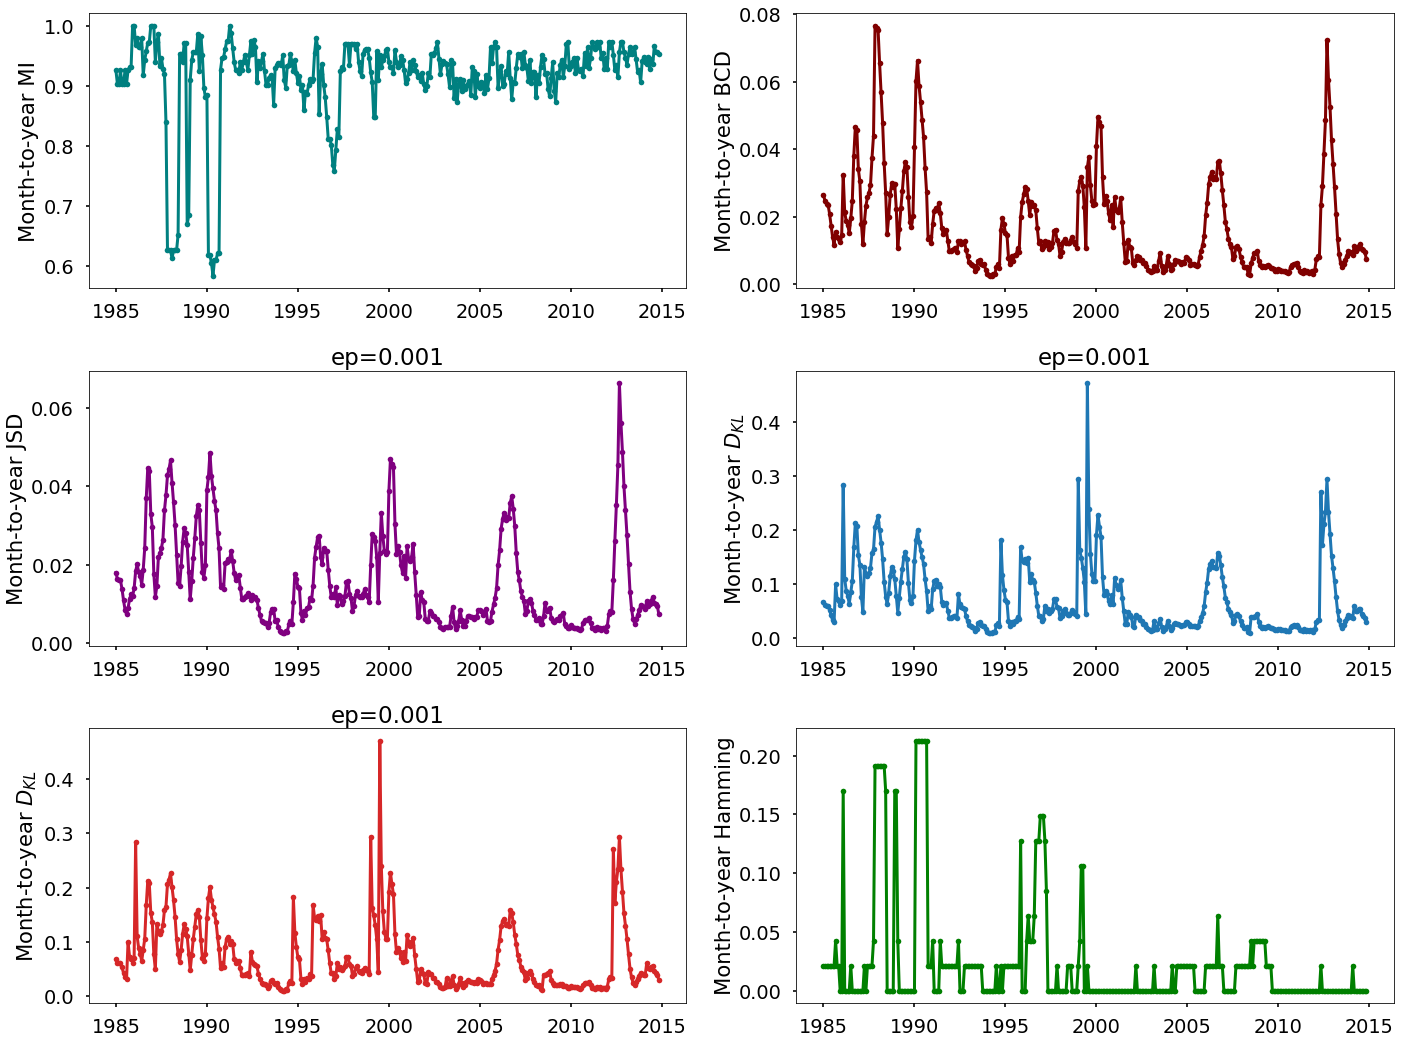

In [12]:
fig, axs = plt.subplots(3,2, figsize=(20,15))

windowsize = 12
axs = axs.reshape((axs.size,))
xticks = np.arange(windowsize,35*12,5*12)
xticklabels = [ str(i) for i in np.arange(1985,2020,5) ]
indices = table.index[windowsize:]

ep = 0.001

# Normalised mutual Information
ax = axs[0]
ax.plot(indices, MIs[ep], '.-', c='teal')
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_ylabel(r'Month-to-year MI')

# Bhattacharya distance
ax = axs[1]
ax.plot(indices, BCDs[ep], '.-', c='maroon')
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_ylabel(r'Month-to-year BCD')

# JSDs:
ax = axs[2]
ax.plot(indices, JSDs[ep], '.-', c='purple')
ax.set_title('ep='+str(ep))
ax.set_ylabel(r'Month-to-year JSD')
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
#ax.set_ylim(-0.1,2.5)
    
# Fill all zeros = False:
ax = axs[3]
ax.plot(indices, KLs_faz_False[ep], '.-')
ax.set_title('ep='+str(ep))
ax.set_ylabel(r'Month-to-year $D_{KL}$')
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
#ax.set_ylim(-0.1,7)

# Fill all zeros = True:
ax = axs[4]
ax.plot(indices, KLs_faz_True[ep], '.-', c='#d62728')
ax.set_title('ep='+str(ep))
ax.set_ylabel(r'Month-to-year $D_{KL}$')
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

# Hamming distance
ax = axs[5]
ax.plot(indices, hammings[ep], '.-', c='g')
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_ylabel(r'Month-to-year Hamming')

plt.tight_layout()
plt.savefig('images/divergence-month-to-year.png', dpi=300)
plt.show()

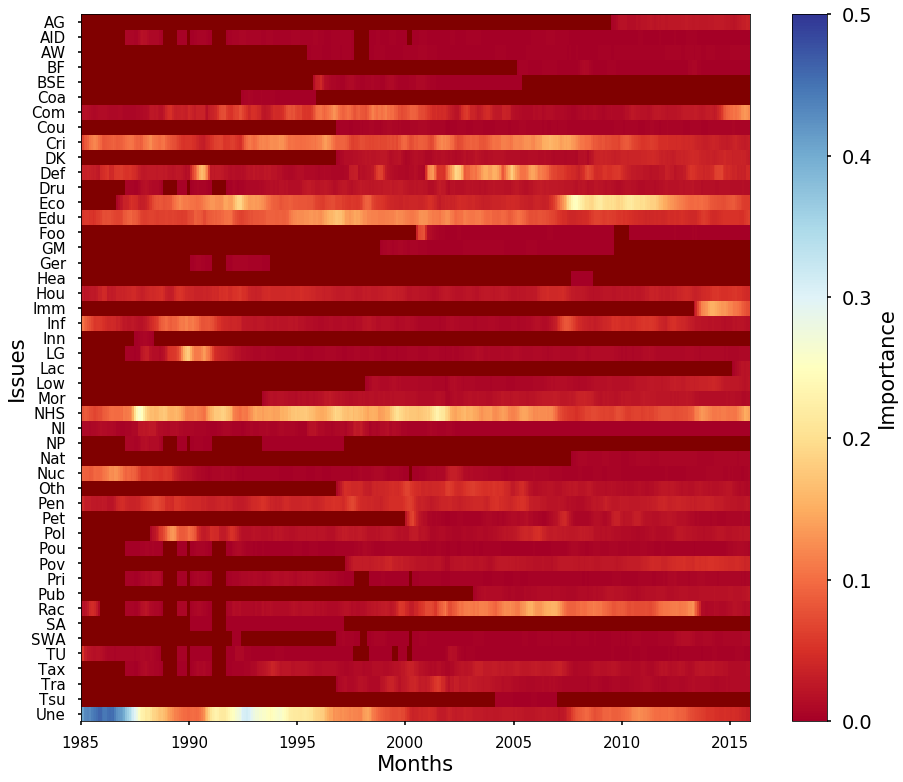

In [13]:
table = table_moving_average
M = table.as_matrix()[:,:-2]

normM = []
for m in M:
    if sum(m)>0:
        normM += [ list(m/sum(m)) ]
    else:
        normM += [ list(m) ]
normM = np.array(normM)

fig, ax = plt.subplots(1, figsize=(15,13))

Mshow = np.flipud(normM.T)
Mshow[Mshow==0.0] = -1

pc = plt.pcolor(Mshow, cmap='RdYlBu')

#pc.cmap.set_under('rosybrown')
pc.cmap.set_under('maroon')
pc.set_clim(0,0.5)

c = plt.colorbar()
c.set_label('Importance')

keys = month_table.keys()[:-2]
yticks = np.arange(len(keys)-1)+0.5
yticklabels = list(reversed(keys.values[:-1]))
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels, fontsize=15)
ax.set_ylabel('Issues')

xticks = np.arange(0,35*12,5*12)
xticklabels = [ str(i) for i in np.arange(1985,2020,5) ]

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, fontsize=15)
ax.set_xlabel('Months')

#plt.savefig('MII-per-month-rolling-mean.png', dpi=200)
plt.show()

In [ ]:
"""
d = table.filter(month_table.keys()[:-3])
dic_sum = { i:j for i,j in zip(d.keys(), (d.as_matrix()>0).sum(axis=0))}

v = sorted(dic_sum.items(), key=lambda kv: kv[1], reverse=True)

for i in v:
    print(i[0], i[0] in MII_names)
    
v
"""

In [ ]:
"""
d = table.filter(month_table.keys()[:-3])
sums = d.sum()
dic_sum = { i:j for i,j in zip(sums.index, sums.values)}

v = sorted(dic_sum.items(), key=lambda kv: kv[1], reverse=True)

for i in v:
    print(i[0], i[0] in MII_names)
    
v
"""

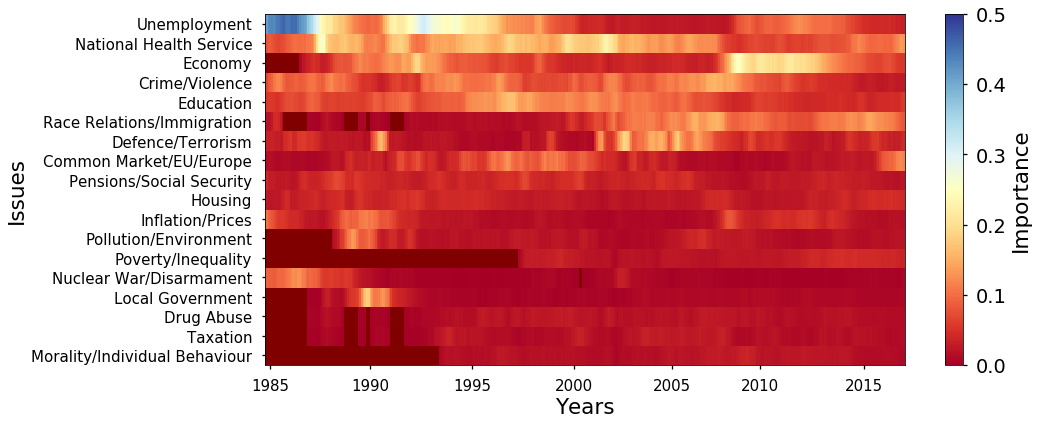

In [15]:
# For IC2S2

table = table_moving_average

M = table.as_matrix()[:,:-2]

# Special hack: add 'Imm'(Immigration) to 'Rac'(Race Relations/Immigration)
M[:,39] += M[:,19]

normM = []
for m in M:
    if sum(m)>0:
        normM += [ list(m/sum(m)) ]
    else:
        normM += [ list(m) ]
normM = np.array(normM)

fig, ax = plt.subplots(1, figsize=(15,6))

Mshow = np.flipud(normM.T)
Mshow[Mshow==0.0] = -1

keys = month_table.keys()[:-3]
#selected_keys = [ 'Une', 'NHS', 'Eco', 'Cri', 'Edu', 'Rac', 'Def', 'Com', 'Pen', 'Hou' ]
selected_keys = ['Une', 'NHS', 'Eco', 'Cri', 'Edu', 'Rac', 'Def', 'Com', 'Pen', 'Hou', \
       'Inf', 'Pol', 'Pov', 'Nuc', 'LG', 'Dru', 'Tax', 'Mor']
selected_indices = np.array([ np.where(keys[::-1]==k)[0][0] for k in selected_keys ])

#Mshow = Mshow[selected_indices]
Mshow = np.flipud(Mshow[selected_indices])
pc = plt.pcolor(Mshow, cmap='RdYlBu')

#pc.cmap.set_under('rosybrown')
pc.cmap.set_under('maroon')
pc.set_clim(0,0.5)

c = plt.colorbar()
c.set_label('Importance')

yticks = np.arange(len(keys.values[selected_indices]))+0.5
yticklabels = list(keys.values[::-1][selected_indices])
yticklabels = [ MII_names[key] for key in yticklabels ][::-1]

ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels, fontsize=15)
ax.set_ylabel('Issues')

#x = [ datetime.strptime(m.replace('Sept','Sep').replace('General Election 1 April 1997','Apr-97'), '%b-%y')  \
#      for m in table.month.values ]
#x = [ s.year + s.month*1.0/12 for s in x ]
x = np.arange(len(table))
xticklabels = [ m.replace('-',' ') for m in table.month if m[:3]=='Jun' and int(m[-1])%5==0 ]
xticklabels = [ m.replace('Jun ','19') if int(m[4])>=8 else m.replace('Jun ','20') for m in xticklabels ]
xticks = [ x[int(i)] for i,m in enumerate(table.month) if m[:3]=='Jun' and int(m[-1])%5==0  ]

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, fontsize=15)
ax.set_xlabel('Years')

plt.tight_layout()
#plt.savefig('MII-month-rolling-mean-ic2s2.svg', dpi=200)
#plt.savefig('MII-month-rolling-mean-ic2s2.png', dpi=200)
plt.show()

In [9]:
MII_names = {
            'Une' : 'Unemployment',
            'NHS' : 'National Health Service',
            'Eco' : 'Economy',
            'Cri' : 'Crime/Violence', 
            'Edu' : 'Education',
            'Rac' : 'Race Relations/Immigration',
            'Def' : 'Defence/Terrorism',
            'Com' : 'Common Market/EU/Europe',
            'Pen' : 'Pensions/Social Security',
            'Hou' : 'Housing',
            'Inf' : 'Inflation/Prices', 
            'Pol' : 'Pollution/Environment', 
            'Pov' : 'Poverty/Inequality', 
            'Nuc' : 'Nuclear War/Disarmament', 
            'LG'  : 'Local Government', 
            'Dru' : 'Drug Abuse', 
            'Tax' : 'Taxation', 
            'Mor' : 'Morality/Individual Behaviour'
            }

all_topics = {
 'AG' : 'Ageing Population/Social Care for the Elderly',
 'AID': 'AIDS',
 'AW' : 'Animal Welfare',
 'BF' : 'Bird Flu/Flu Pandemic',
 'BSE': 'BSE/Beef',
 'Coa': 'Coal Review/Pit Closures',
 'Com': 'Common Market/EU/Europe/Single European Currency',
 'Cou': 'Countryside/Rural Life',
 'Cri': 'Crime/Law & Order/Violence/Vandalism',
 'DK' : "Don't know",
 'Def': 'Defence/Foreign Affairs/International Terrorism',
 'Dru': 'Drug Abuse',
 'Eco': 'Economy/Economic Situation',
 'Edu': 'Education/Schools',
 'Foo': 'Foot And Mouth Outbreak/Farming Crisis',
 'GM' : 'GM/GM (Genetically Modified) Foods',
 'Ger': 'German Reunification/Eastern Europe',
 'Hea': 'Heathrow/third runway at Heathrow',
 'Hou': 'Housing',
 'Inf': 'Inflation/Prices',
 'Inn': 'Inner Cities',
 'Imm': 'Immigration',
 'Lac': 'Lack of faith in govt/politics',
 'LG' : 'Local Government/Council Tax/Poll Tax',
 'Low': 'Low Pay/Minimum Wage/Fair Wages',
 'Mor': 'Morality/Individual Behaviour',
 'NHS': 'NHS / Hospitals / Health Care',
 'Nat': 'Nationalisation/Government control of institutions',
 'NI' : 'Northern Ireland',
 'NP' : 'Nuclear Power/Fuels',
 'Nuc': 'Nuclear Weapons/Nuclear War/Disarmament',
 'Oth': 'Other',
 'Pen': 'Pensions/Social Security',
 'Pet': 'Petrol Prices/Fuel',
 'Pol': 'Pollution/Environment',
 'Pou': 'Pound/Exchange Rate/Value Of Pound',
 'Pov': 'Poverty/Inequality',
 'Pri': 'Privatisation',
 'Pub': 'Public Services In General',
 'Rac': 'Race Relations/Immigration/Immigrants',
 'SA' : 'Scottish Assembly',
 'SWA': 'Scottish/Welsh Assembly/Devolution Constitutional Reform',
 'TU' : 'Trade Unions/Strikes',
 'Tax': 'Taxation',
 'Tra': 'Transport/Public Transport',
 'Tsu': 'Tsunami/South East Asia',
 'Une': 'Unemployment/Factory Closure/Lack Of Industry'
}

## 2 - Make proportion plots

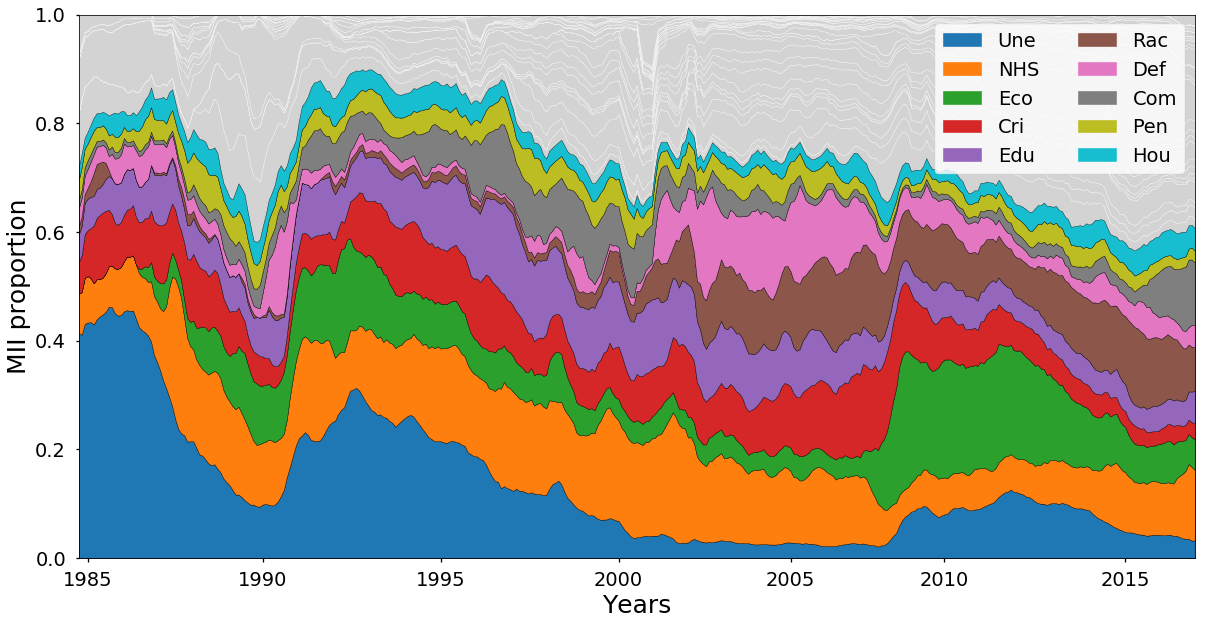

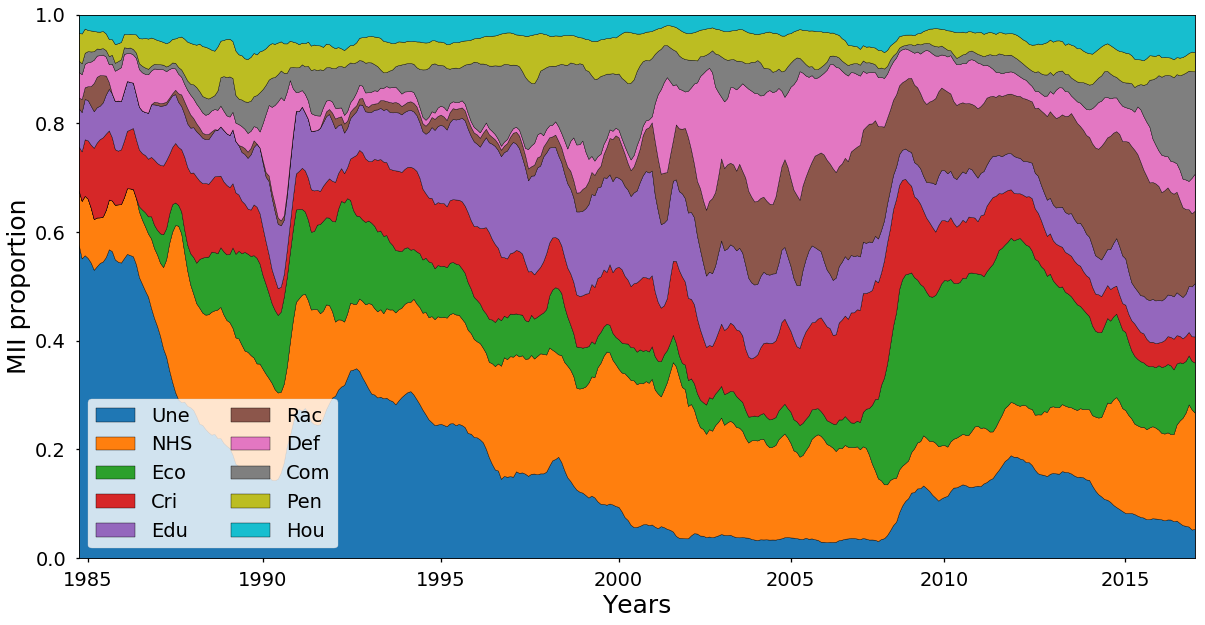

In [21]:
"""
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

cmap = plt.cm.get_cmap("tab20c", 600)
colors = [ cmap(np.random.randint(300,600)) if i%2==0 else cmap(np.random.randint(0,300)) for i in range(len(y)) ]
colors = np.random.rand(len(y),3)*0.7 + 0.2
"""

M = table.as_matrix()[:,:-2]

# Special hack: add 'Imm'(Immigration) to 'Rac'(Race Relations/Immigration)
M[:,39] += M[:,19]

normM = []
for m in M:
    if sum(m)>0:
        normM += [ list(m/sum(m)) ]
    else:
        normM += [ list(m) ]
normM = np.array(normM)

y = normM.T.astype(float)
x = range(len(y[0]))

n_MIIs = 10

sums = np.array([ sum(i) for i in y ])
index_sort_all = np.argsort(sums)[::-1]
min_sum = sums[index_sort_all][n_MIIs]

colors = (['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
           '#8c564b', '#e377c2', '#7f7f7f','#bcbd22', '#17becf']*5)[:len(y)]

colors = [ colors[i] if i<n_MIIs else 'lightgrey' for i in range(len(y)) ]

fig, ax = plt.subplots(1, figsize=(20,10))

ax.stackplot(x, y[index_sort_all,:],          colors=colors, edgecolor='whitesmoke')
ax.stackplot(x, y[index_sort_all,:][:n_MIIs], colors=colors, edgecolor='k')

x = np.arange(len(table))
xticklabels = [ m.replace('-',' ') for m in table.month if m[:3]=='Jun' and int(m[-1])%5==0 ]
xticklabels = [ m.replace('Jun ','19') if int(m[4])>=8 else m.replace('Jun ','20') for m in xticklabels ]
xticks = [ x[int(i)] for i,m in enumerate(table.month) if m[:3]=='Jun' and int(m[-1])%5==0  ]

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_ylim(0,1)
ax.set_xlim(0,len(x)-1)

plt.legend(table.keys()[index_sort_all][:n_MIIs], ncol=2, loc=1)
plt.xlabel('Years',fontsize=25)
plt.ylabel('MII proportion',fontsize=25)
#plt.savefig('MII-per-month-rolling-mean-proportions.png', dpi=200)
#plt.savefig('MII-per-month-rolling-mean-proportions.svg', dpi=200)
plt.show()


# Make plot with top MIIs

y = y[index_sort_all][:n_MIIs,:]
x = range(len(y[0]))

for i in x:
    y[:,i] /= sum(y[:,i])

sums = np.array([ sum(i) for i in y ])
index_sort = np.argsort(sums)[::-1]
min_sum = 0

fig, ax = plt.subplots(1, figsize=(20,10))

ax.stackplot(x, y, colors=colors, edgecolor='k')

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_ylim(0,1)
ax.set_xlim(0,len(x)-1)

plt.legend(table.keys()[index_sort_all][:n_MIIs], ncol=2, loc=3)
plt.xlabel('Years',fontsize=25)
plt.ylabel('MII proportion',fontsize=25)
#plt.savefig('MII-per-month-rolling-mean-proportions-top.png', dpi=200)
plt.show()

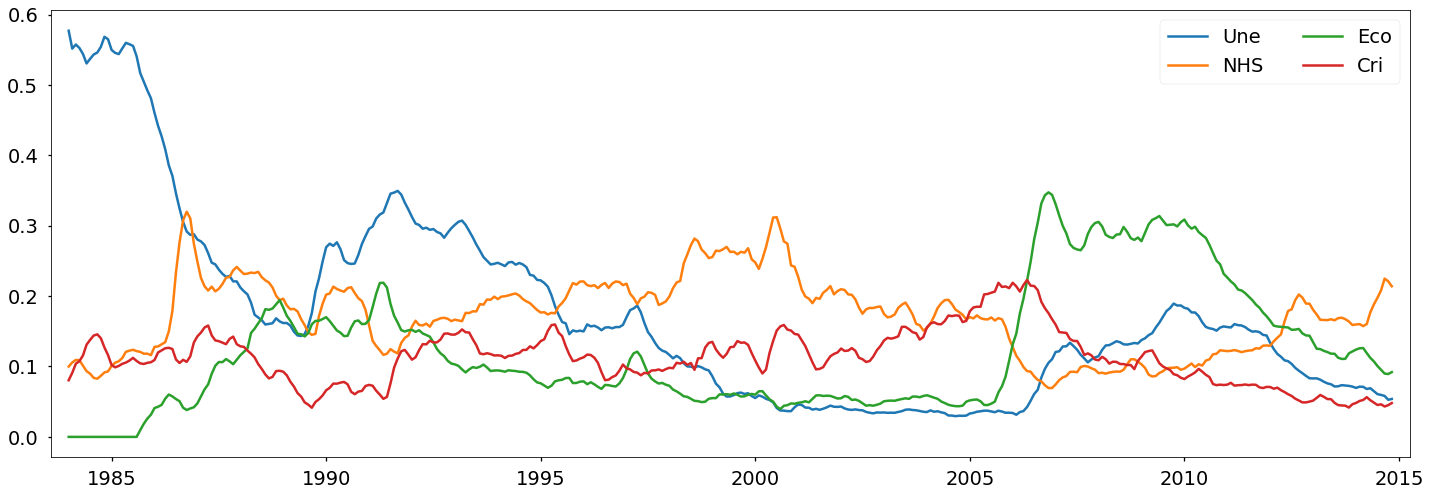

In [145]:
fig, ax = plt.subplots(1,figsize=(20,7))

#for i in range(n_MIIs):
for i in range(4):
    plt.plot(y[i], label=keys[index_sort_all][i])   
    
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_xlim(-5+min(x),max(x)+5)
#plt.yscale('log')
plt.legend(loc=1, ncol=2)

plt.tight_layout()
plt.savefig('images/time-series.png', dpi=200)
plt.show()

## Rank

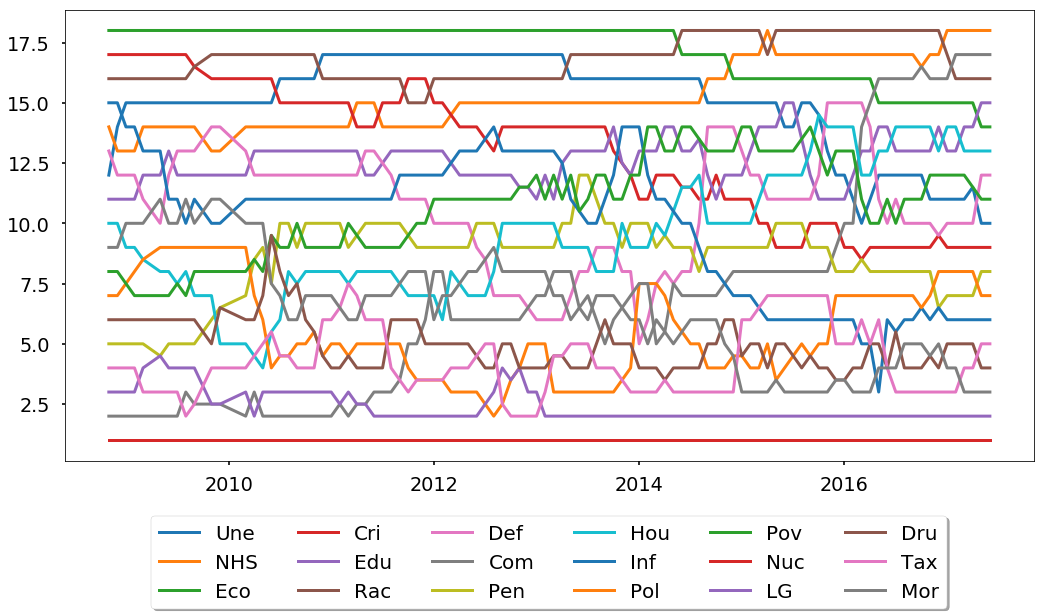

In [52]:
n_MIIs = 10

keys = month_table.keys()[:-3]
selected_keys = [ 'Une', 'NHS', 'Eco', 'Cri', 'Edu', 'Rac', 'Def', 'Com', 'Pen', 'Hou' ]
selected_keys = ['Une', 'NHS', 'Eco', 'Cri', 'Edu', 'Rac', 'Def', 'Com', 'Pen', 'Hou', 'Inf', 'Pol', 'Pov', 'Nuc', 'LG', 'Dru', 'Tax', 'Mor']
#selected_keys = keys

selected_indices = np.array([ np.where(keys==k)[0][0] for k in selected_keys ])

M = table.as_matrix()[:,:-2]

# Special hack: add 'Imm'(Immigration) to 'Rac'(Race Relations/Immigration)
M[:,39] += M[:,19]

# If I want to take other issues into consideration, comment the line below
M = M[:,selected_indices]

normM = []
for m in M:
    if sum(m)>0:
        normM += [ list(m/sum(m)) ]
    else:
        normM += [ list(m) ]
normM = np.array(normM)

ranks = np.array([ pd.Series(m).rank().values for m in normM ])

for i in range(normM.shape[0]):
    for j in range(normM.shape[1]):
        if normM[i,j] == 0:
            ranks[i,j] = 0

#yticks = np.arange(len(keys.values[selected_indices]))+0.5
#yticklabels = list(keys.values[::-1][selected_indices])
#yticklabels = [ MII_names[key] for key in yticklabels ][::-1]

window = 100
#window = 400

fig, ax = plt.subplots(1,figsize=(15,7))

x = [ datetime.strptime(m.replace('Sept','Sep').replace('General Election 1 April 1997','Apr-97'), '%b-%y')  \
      for m in table.month.values ]
x = [ s.year + s.month*1.0/12 for s in x ]

#x = np.arange(len(table))
#xticklabels = [ m.replace('-',' ') for m in table.month if m[:3]=='Jun' and int(m[-1])%5==0 ]
#xticklabels = [ m.replace('Jun ','19') if int(m[4])>=8 else m.replace('Jun ','20') for m in xticklabels ]
#xticks = [ x[int(i)] for i,m in enumerate(table.month) if m[:3]=='Jun' and int(m[-1])%5==0  ]


#for i in selected_indices:
for i in range(len(selected_indices)):
    plt.plot(x[-window:],ranks[-window:,i], label=keys[selected_indices][i])   

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=6, fontsize=20)

#plt.legend(loc=8, ncol=2)

plt.tight_layout()
#plt.savefig('images/MII_rank_dynamics.png',dpi=200, bbox_inches='tight')
plt.show()

## And here's the Kendall-Tau distance,

a measure of how rankings differ, for the top 18 issues:

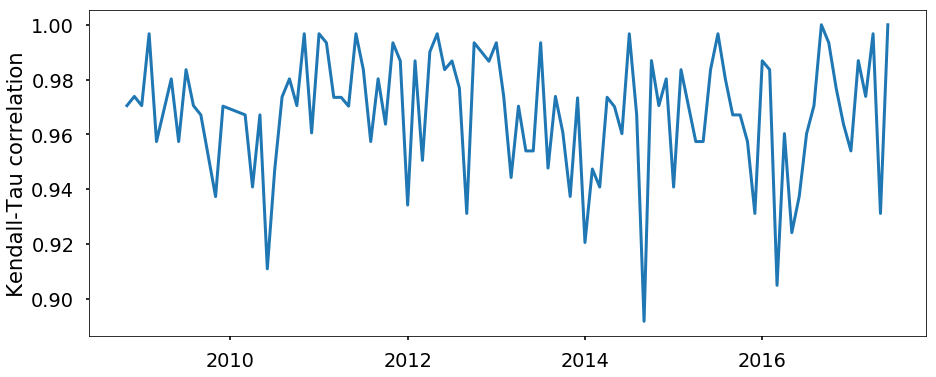

In [57]:
# https://en.wikipedia.org/wiki/Kendall_tau_distance
# https://en.wikipedia.org/wiki/Kendall_rank_correlation_coefficient
    
from scipy.stats import kendalltau

taus = []
ps   = []
for Mi,Mj in zip(M[:-1], M[1:]):
    tau, p = kendalltau(Mi,Mj)
    #taus += [ tau*(len(Mi)) ]
    taus += [ tau ]
    ps   += [p]
    
plt.figure(figsize=(15,6))
#plt.plot(x[1:], taus)
plt.plot(x[-window:], taus[-window:])
plt.ylabel('Kendall-Tau correlation')
plt.show()

## What about variance over a window?
Actually what I need is to look at variance in the abscence of external events.

In [64]:
table = month_table
x = [ datetime.strptime(m.replace('Sept','Sep').replace('General Election 1 April 1997','Apr-97'), '%b-%y')  \
      for m in table.month.values ]
time = [ s.year + s.month*1.0/12 for s in x ]

In [62]:
# 1 - Make a running mean with a large window
# 2 - With the running mean, make the running variance

N = 10

means_dic = {}
stds_dic = {}
for key in month_table.keys()[:-3]:
    #new_df_dic[key] = running_mean(month_table[key].values, N=N)
    ts = pd.Series(month_table[key].values)
    means_dic[key] = ts.rolling(center=False,window=N).mean()
    stds_dic[key]  = ts.rolling(center=False,window=N).std()

new_df_dic = {}
for key in stds_dic:
    new_df_dic[key] = [ (i,j) for i,j in zip ( means_dic[key], stds_dic[key] )]

#new_df_dic['month'] = month_table['month'].values[int((N-1)/2):-int((N-1)/2)]
#new_df_dic['year']  = month_table['year'].values[int((N-1)/2):-int((N-1)/2)]
    
table_moving_average = pd.DataFrame(new_df_dic)
table_moving_average.tail()

,AG,AID,AW,BF,BSE,Coa,Com,Cou,Cri,DK,...,Pri,Pub,Rac,SA,SWA,TU,Tax,Tra,Tsu,Une
370,"(8.8, 2.0439612955674527)","(0.325, 0.23717082451262733)","(1.4, 0.5163977794943222)","(0.325, 0.23717082451263108)","(0.0, 7.499058617593968e-08)","(0.0, 0.0)","(38.2, 6.373556481449132)","(1.7, 0.48304589153964733)","(10.8, 2.0976176963401394)","(12.3, 1.1595018087284092)",...,"(2.0, 0.666666666666668)","(6.6, 0.9660917830792987)","(5.6, 1.1737877907768706)","(0.0, 0.0)","(2.4, 1.1737877907772685)","(1.3, 0.6749485577105583)","(4.2, 1.1352924243950981)","(4.3, 0.8232726023485804)","(0.0, 0.0)","(14.8, 2.097617696340817)"
371,"(9.1, 2.131770260709265)","(0.4, 0.316227766016837)","(1.5, 0.5270462766947298)","(0.325, 0.23717082451263108)","(0.0, 7.499058617593968e-08)","(0.0, 0.0)","(39.8, 6.6466365763277455)","(1.7, 0.48304589153964733)","(11.1, 2.1832697191748878)","(12.3, 1.1595018087284092)",...,"(2.1, 0.7378647873726231)","(6.6, 0.9660917830792987)","(5.7, 1.059349905470943)","(0.0, 0.0)","(2.8, 1.3165611772087675)","(1.3, 0.6749485577105583)","(4.3, 1.2516655570345767)","(4.4, 0.8432740427115831)","(0.0, 0.0)","(14.7, 2.1108186931988535)"
372,"(9.5, 2.2730302828309763)","(0.4, 0.316227766016837)","(1.6, 0.5163977794943221)","(0.325, 0.23717082451263108)","(0.0, 7.499058617593968e-08)","(0.0, 0.0)","(40.3, 6.848357467305576)","(1.6, 0.516397779494322)","(11.2, 2.097617696340144)","(12.3, 1.1595018087284092)",...,"(2.1, 0.7378647873726231)","(6.7, 1.159501808728408)","(5.3, 1.2516655570341944)","(0.0, 0.0)","(2.6, 1.2649110640673527)","(1.3, 0.6749485577105583)","(4.3, 1.2516655570345767)","(4.2, 0.6324555320336963)","(0.0, 0.0)","(14.2, 2.0976176963408233)"
373,"(10.6, 3.3399933466334266)","(0.475, 0.3622844186547351)","(1.6, 0.5163977794943221)","(0.4, 0.3162277660168399)","(0.0, 7.499058617593968e-08)","(0.0, 0.0)","(41.4, 6.022181221672651)","(1.6, 0.516397779494322)","(11.1, 1.9692073983654197)","(12.1, 1.3703203194062996)",...,"(2.3, 0.9486832980505149)","(7.2, 1.7511900715418278)","(5.4, 1.349897115420757)","(0.0, 0.0)","(2.6, 1.2649110640673527)","(1.3, 0.6749485577105583)","(4.8, 1.2292725943057223)","(4.3, 0.4830458915396748)","(0.0, 0.0)","(13.9, 2.1832697191755446)"
374,"(11.2, 3.3598941782277745)","(0.4, 0.31622776601683705)","(1.6, 0.5163977794943221)","(0.325, 0.23717082451263108)","(0.0, 7.499058617593968e-08)","(0.0, 0.0)","(42.0, 5.597618541248892)","(1.7, 0.6749485577105524)","(11.2, 2.097617696340144)","(11.7, 1.636391694484477)",...,"(2.4, 1.074967699773141)","(7.7, 2.311805451253295)","(5.6, 1.577621275492936)","(0.0, 0.0)","(2.6, 1.2649110640673527)","(1.4, 0.6992058987801062)","(4.8, 1.2292725943057223)","(4.4, 0.6992058987801195)","(0.0, 0.0)","(13.7, 2.0575065816019973)"


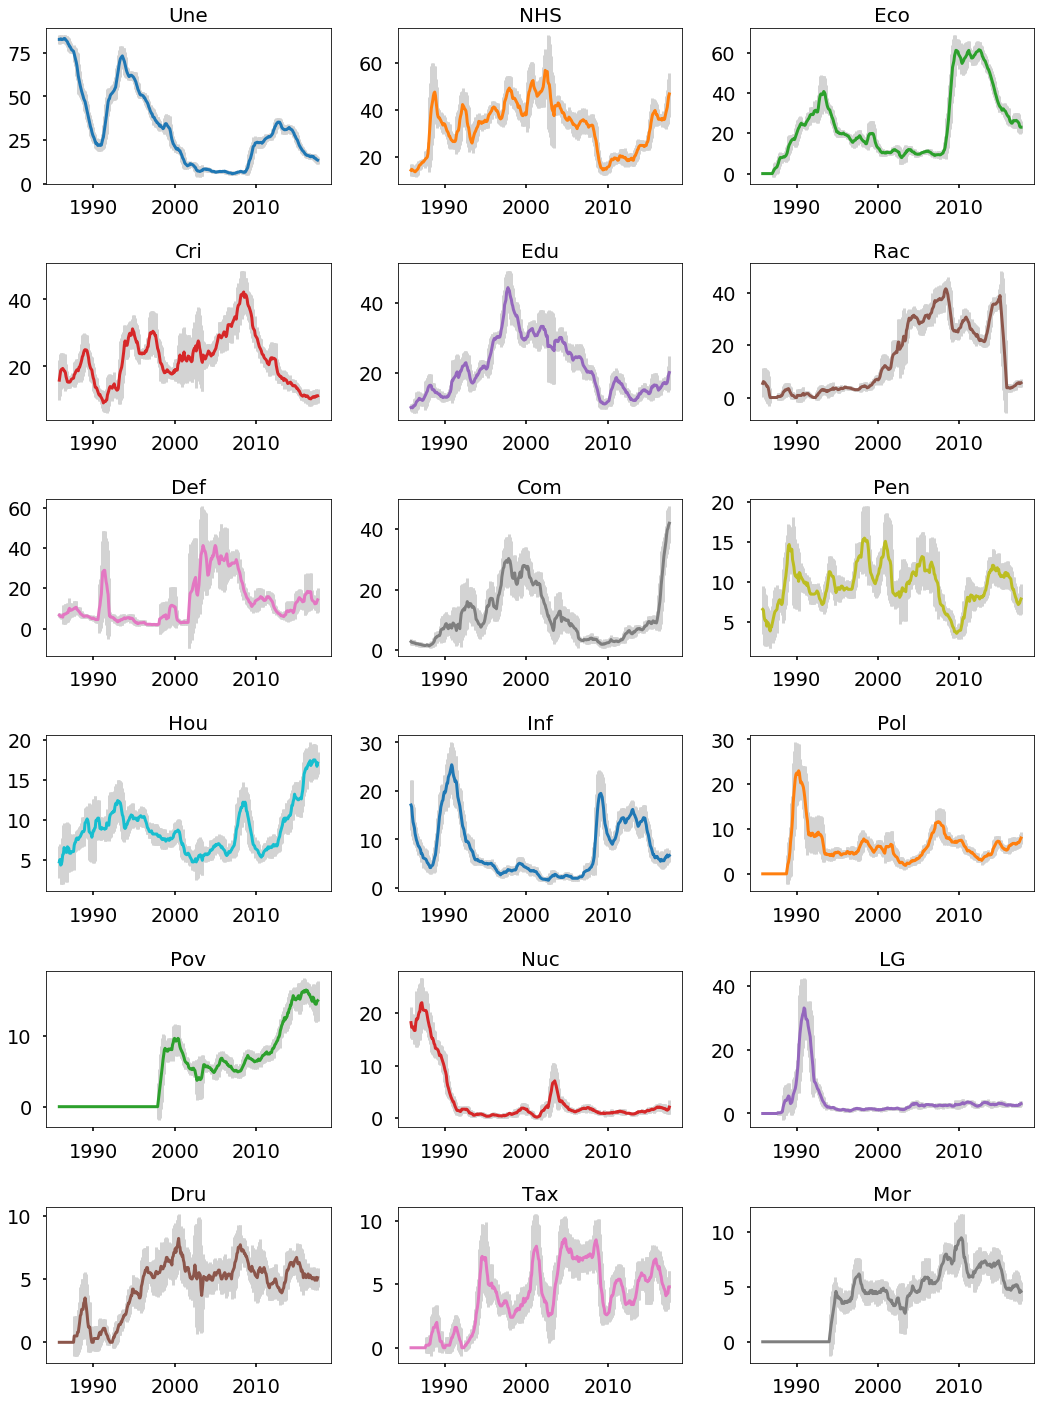

In [74]:
selected_keys = selected_keys = ['Une', 'NHS', 'Eco', 'Cri', 'Edu', 'Rac', 'Def', 'Com', 'Pen', 'Hou', 'Inf', 'Pol', 'Pov', 'Nuc', 'LG', 'Dru', 'Tax', 'Mor']
table = table_moving_average.filter(selected_keys)
keys = table.keys()

M = table.as_matrix()

fig, axs = plt.subplots(6,3,figsize=(15,20))
axs = axs.flatten()
#axs[-1].axis('off')

colors = (['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
           '#8c564b', '#e377c2', '#7f7f7f','#bcbd22', '#17becf']*5)[:len(M[0])]

for key, ax, c in zip(keys, axs, colors):

    y    = [ i[0] for i in table[key].values ]
    yerr = [ i[1] for i in table[key].values ]
    x    = time
    ax.errorbar(x,y,yerr=yerr, color=c, ecolor='lightgray')
    ax.set_title(key, fontsize=20)
    #ax.set_ylim(-1,80)


plt.tight_layout()
plt.savefig('images/MII-std-time-series.png', dpi=200)
plt.show()

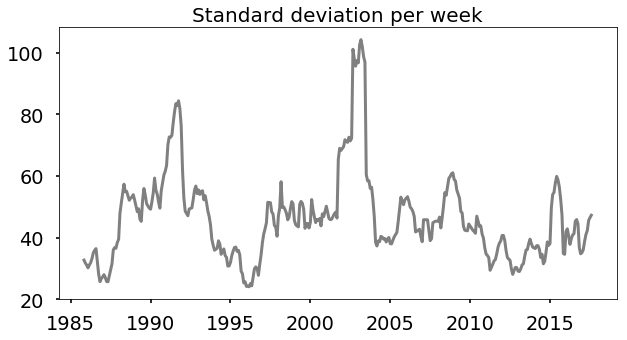

In [75]:
fig, ax = plt.subplots(1, figsize=(10,5))

stds_per_week = [ sum([ mij[1] for mij in m_week ]) for m_week in M ]
y    = stds_per_week
x    = time
ax.plot(x,y,'grey')
ax.set_title('Standard deviation per week', fontsize=20);
plt.savefig('images/MII-std-over-time.png', dpi=200)
plt.show()

# Other pieces of code
Nothing from this point onwards was super useful.

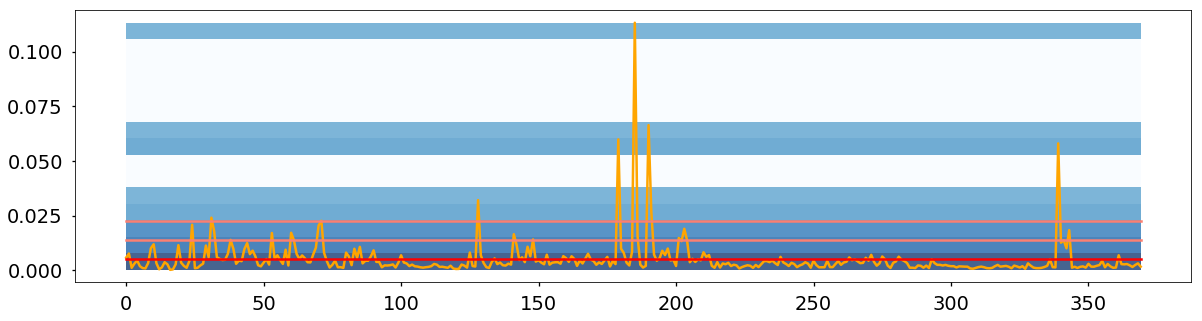

In [79]:
z = KLs_faz_True[ep]
L = len(z)

from sklearn.utils import resample

z2 = resample(z, n_samples=1000000, random_state=i)

cm = plt.cm.Blues
counts, bins = np.histogram(z2, bins=15)
sumcounts = sum(counts)
counts = np.array([ np.log10((i+1)) for i in counts])
colours = np.array([ cm(i/max(counts)) for i in counts])

fig, ax = plt.subplots(1,figsize=(20,5))

ax.plot(z, c='orange')
ax.plot(range(L), [np.mean(z2)]*L, c='red')
ax.plot(range(L), [np.mean(z2) +   np.std(z2)]*L, c='salmon')
ax.plot(range(L), [np.mean(z2) + 2*np.std(z2)]*L, c='salmon')

bottoms = bins[:-1]
tops    = bins[1:]

for b,t,c in zip(bottoms, tops, colours):
    ax.fill_between( range(L), [b]*L, [t]*L, facecolor=c, alpha=0.75)

## Coherence measures

Defining coherence as the average distance between points in a set (say, a year),
- calculate the coherence of every year,
- and the rolling mean coherence of every 3- and 6-months block
- also measure the mean distance between all months in a block/year and the months in the previous adjacent block, to talk about how far a block has gone.

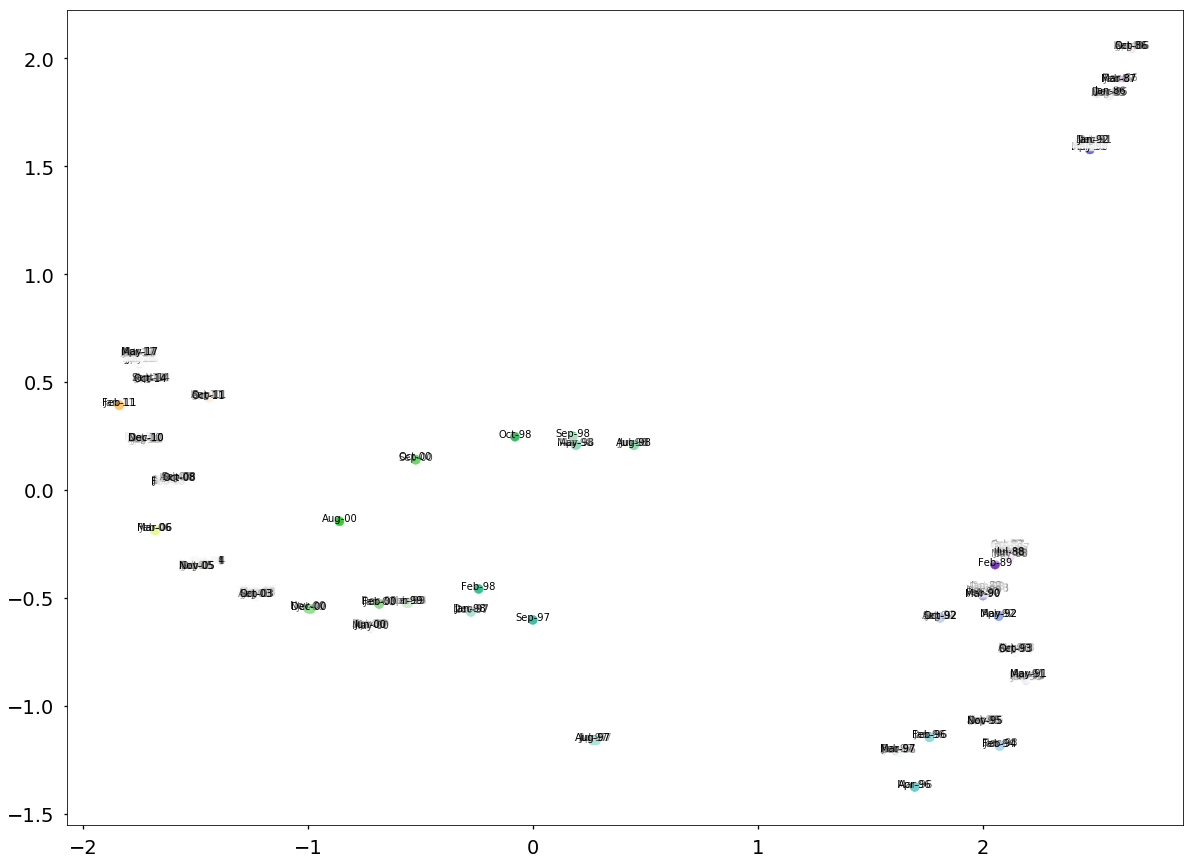

In [147]:
from sklearn import decomposition

centers = [[1, 1], [-1, -1], [1, -1]]
X = normM
Y = np.arange(len(X))

pca = decomposition.PCA(n_components=2)
pca.fit(X)
X = pca.transform(X)

cmap = plt.cm.spectral

fig, ax = plt.subplots(1, figsize=(20,15))

ax.scatter(X[:, 0], X[:, 1], c=Y, cmap=cmap)# , edgecolor='k')

dates = table.month.values

for xy,month in zip(X,dates):
    x,y = xy
    ax.text(x,y, month,
          horizontalalignment='center',
          bbox=dict(alpha=.25, edgecolor='w', facecolor='w'))


plt.show()

In [253]:
def decoherence1(xs,metric='euclidean',ep=0.01, faz=True):
    total_coh = 0
    for p in xs:
        for q in xs:
            total_coh += novelty(p,q,metric=metric,ep=ep,faz=faz)
    return total_coh

def decoherence2(xs,ys,metric='euclidean',ep=0.01, faz=True):
    total_coh = 0
    for p in xs:
        for q in ys:
            total_coh += novelty(p,q,metric=metric,ep=ep,faz=faz)
    return total_coh

In [254]:
blocks_1year_x = []
blocks_1year_y = []
years = list(set(month_table.year))
for year in years:
    df = month_table[month_table.year==year]
    #blocks_1year_y += [ df.as_matrix()[:,:-3] ]
    blocks_1year_y += [ [i/sum(i) if sum(i)>0 else i*0 for i in df.as_matrix()[:,:-3] ] ]
    
    blocks_1year_x += [ year ]

all_N        = [ 1 ]
all_blocks_x = [ blocks_1year_x ]
all_blocks_y = [ blocks_1year_y ]

for N in [3,6]:
    dic_running_mean = { key:running_mean(month_table[key].values, N=N) for key in month_table.keys()[:-3] }
    M = pd.DataFrame(dic_running_mean).as_matrix()
    blocks_x = []
    blocks_y = []
    #for idx in np.arange(0, len(dic_running_mean[keys[0]])-N, N):
    for idx in range(len(dic_running_mean[keys[0]])):
        blocks_x += [ float(month_table.year.values[idx]) + (1.0/12)*float(month_table.date.values[idx][5:7]) ]
        blocks_y += [ [i/sum(i) for i in M[idx:idx+N]] ]
        
    all_blocks_x += [ blocks_x ]
    all_blocks_y += [ blocks_y ]
    all_N        += [ N ]

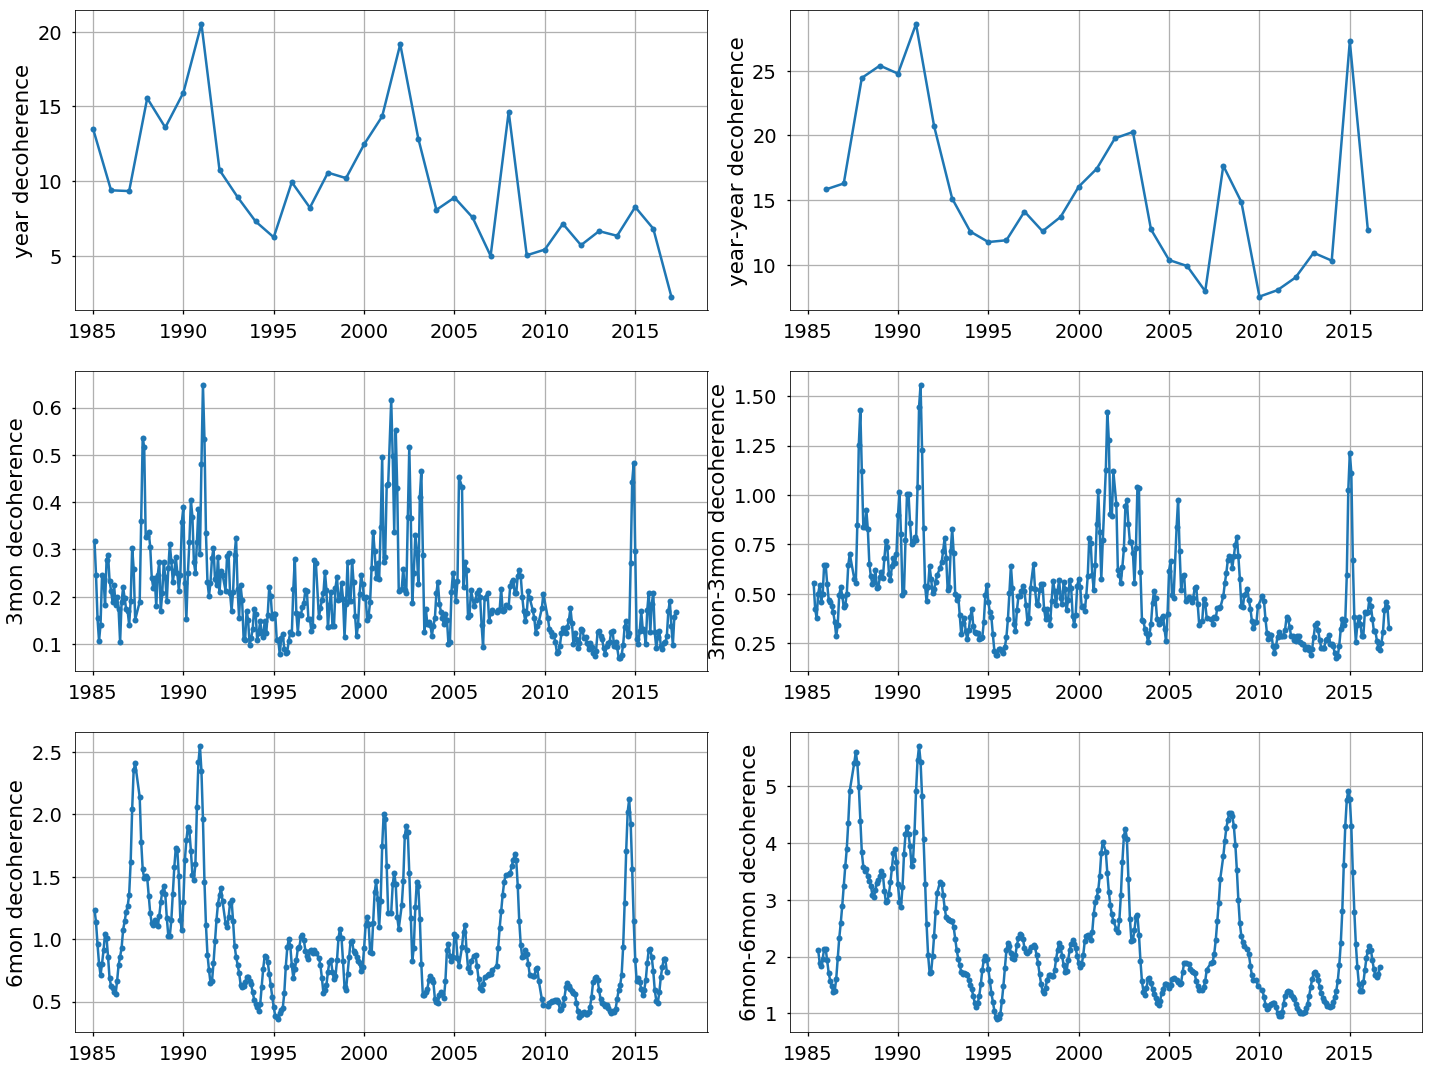

In [255]:
metric = 'euclidean'

dec_1 = [[ decoherence1(xs, metric=metric) for xs in blocks ] for blocks in all_blocks_y]
dec_2 = [[ decoherence2(blocks[i], blocks[i-N], metric=metric) for i in range(1,len(blocks)) ] \
                                                                        for blocks,N in zip(all_blocks_y,all_N) ]

xs = []
ys = []
for i1, i2, x12, N in zip(dec_1, dec_2, all_blocks_x, all_N):
    ys += [ i1[:len(i1)-(N-1)], i2[(N-1):-N] ]
    xs += [ x12[:len(x12)-(N-1)], x12[N:-N] ]

    
ylabels = [
            'year decoherence', 'year-year decoherence',
            '3mon decoherence', '3mon-3mon decoherence',
            '6mon decoherence', '6mon-6mon decoherence'
          ]
#ylims   = [ (0,10000) ]*2 + [ (0,330) ]*2 + [ (0,1800) ]*2 
ylims   = [ (0,35) ]*2 + [ (0,1.75) ]*2 + [ (0,6) ]*2 

fig, axs = plt.subplots(3,2,figsize=(20,15))
axs = [ axs[0,0], axs[0,1], axs[1,0], axs[1,1], axs[2,0], axs[2,1] ]

for ax,x,y,ylabel,ylim in zip(axs,xs,ys,ylabels,ylims):
    ax.grid()
    ax.plot(x, y, '.-', ms=12)
    ax.set_ylabel(ylabel)
    #ax.set_ylim(ylim)
    ax.set_xlim(1984,2019)
    
plt.tight_layout()
plt.show()

In [ ]:
# Make plot that Helen wants

M = table.as_matrix()[:,:-2]

# Special hack: add 'Imm'(Immigration) to 'Rac'(Race Relations/Immigration)
M[:,39] += M[:,19]

normM = []
for m in M:
    if sum(m)>0:
        normM += [ list(m/sum(m)) ]
    else:
        normM += [ list(m) ]
normM = np.array(normM)


"""
ten_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
              '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

colors = ['lightgrey']*len(y)

for i,idx in enumerate(selected_indices[:10]):
    colors[idx] = ten_colors[i]
    #print("Painting colors",idx,"of",ten_colors[i],":",keys[idx])
    
   
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

cmap = plt.cm.get_cmap("tab20c", 600)
colors = [ cmap(np.random.randint(300,600)) if i%2==0 else cmap(np.random.randint(0,300)) for i in range(len(y)) ]
"""
colors = (['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
           '#8c564b', '#e377c2', '#7f7f7f','#bcbd22', '#17becf']*5)[:len(y)]

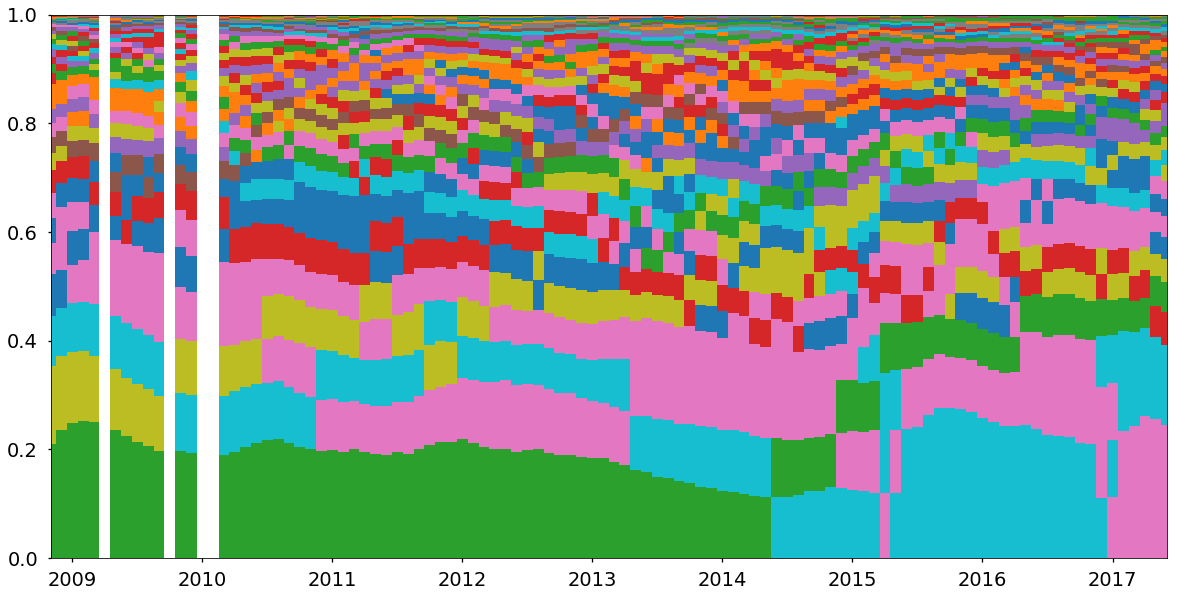

In [291]:
fig, ax = plt.subplots(1,figsize=(20,10))

window = 100
for timestep in range(len(normM)-window,len(normM)):
    value_colors = [ (i,j) for i,j in zip(normM[timestep],colors) ]
    heights_colors  = sorted( value_colors, key=lambda x:-x[0] )
    prev_bottom = 0
    for height, color in heights_colors:
        ax.bar(x[timestep], height, bottom=prev_bottom, color=color, width=0.084) 
        prev_bottom += height
            
ax.set_xlim(min(x[-window:]),max(x[-window:]))
plt.savefig('images/ordered_proportions.png',dpi=200)
plt.show()

## Let's try measuring variance over time

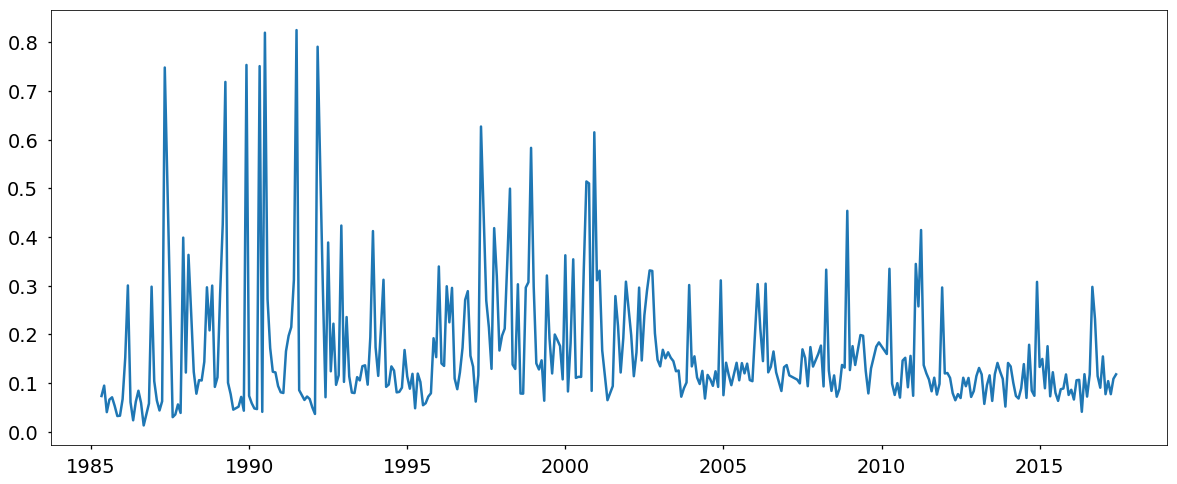

In [69]:
stds = []

for Mi,Mj in zip(M[:-1], M[1:]):
    s    = (Mi+Mj)/2
    #s    = [ max(i,j) for i,j in zip(Mi,Mj) ]
    diff = (Mi-Mj)
    std = np.std([ i/j if j!=0 else 0 for i,j in zip(diff,s)])
    
    #std = np.std([ (i-j)/i for i,j in zip(Mi,Mj) if i*j!=0 ])
    
    stds += [ std ]
    
plt.figure(figsize=(20,8))
plt.plot(x[1:], stds)
#plt.plot(x[-window:], stds[-window:])
plt.show()

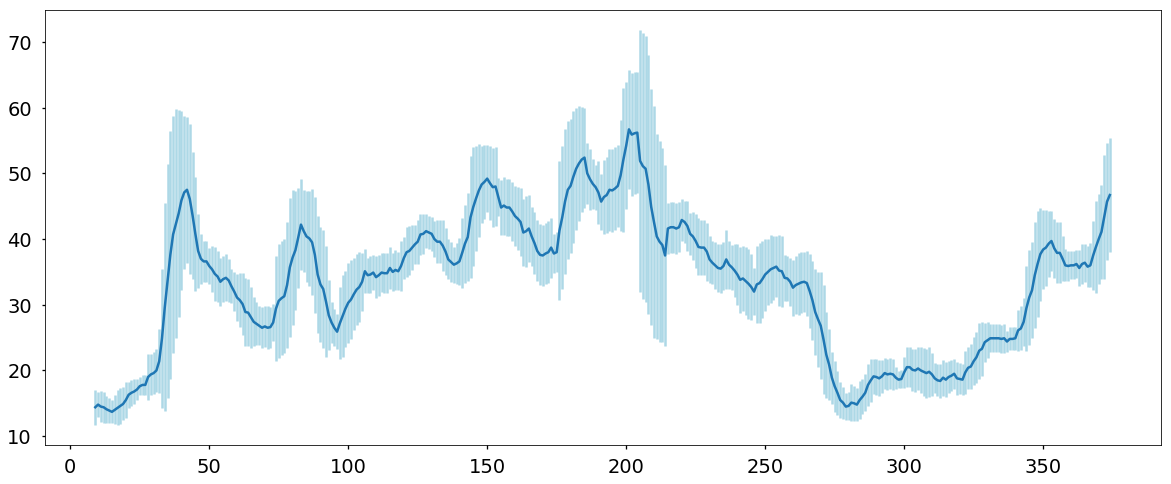

In [238]:
table = table_moving_average

M = table.as_matrix()

# Special hack: add 'Imm'(Immigration) to 'Rac'(Race Relations/Immigration)
#M[:,39] += M[:,19]

plt.figure(figsize=(20,8))

key='Def'

y    = [ i[0] for i in table[key] ]
yerr = [ i[1] for i in table[key] ]
x    = range(len(y))
plt.errorbar(x,y,yerr=yerr, ecolor='lightblue')

plt.show()

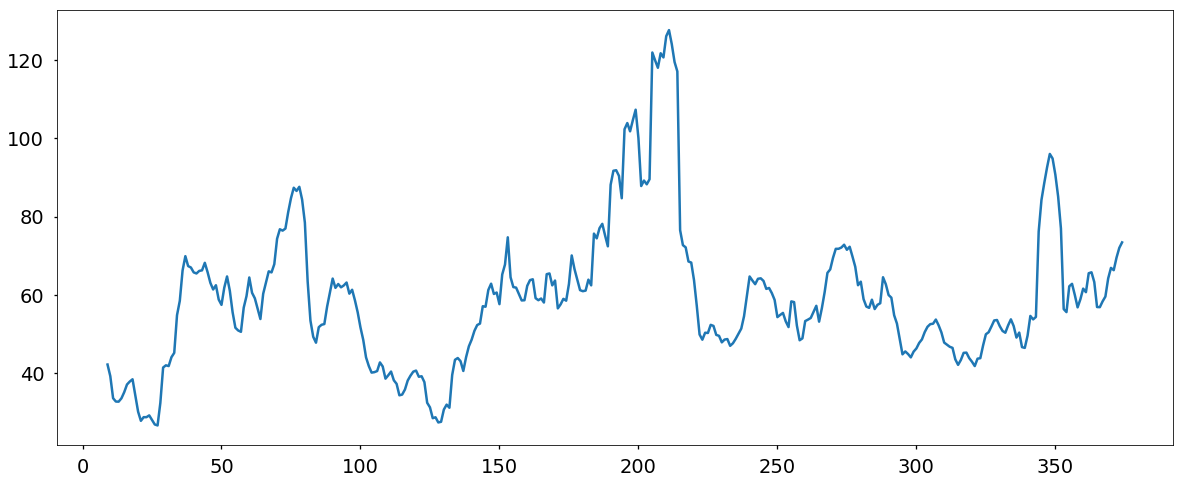

In [209]:
stds_per_week = [ sum([ mij[1] for mij in m_week ]) for m_week in M ]

plt.figure(figsize=(20,8))
y    = stds_per_week
x    = range(len(stds_per_week))
plt.plot(x,y)
plt.show()

In [ ]:
"""
# Normalised mutual Information and Bhattacharya distance

fig, axs = plt.subplots(1,2, figsize=(20,5))

xticks = np.arange(windowsize,35*12,5*12)
xticklabels = [ str(i) for i in np.arange(1985,2020,5) ]
indices = table.index[windowsize:]

ax = axs[0]
ax.plot(indices, MIs[ep], '.-', c='teal')
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_ylabel(r'Month-to-year MI')

ax = axs[1]
ax.plot(indices, BCDs[ep], '.-', c='maroon')
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_ylabel(r'Month-to-year BCD')

#plt.savefig('images/monthly-MI.png',dpi=200)
#plt.show()

# JSDs:

fig, axs = plt.subplots(2,2,figsize=(20,10))
axs = [ axs[0,0], axs[0,1], axs[1,0], axs[1,1] ]

for ep,ax in zip(eps,axs):
    ax.plot(indices, JSDs[ep], '.-', c='purple')
    ax.set_title('ep='+str(ep))
    ax.set_ylabel(r'Month-to-year JSD')
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    #ax.set_ylim(-0.1,2.5)
    
plt.tight_layout()
#plt.show()

# Fill all zeros = False:

fig, axs = plt.subplots(2,2,figsize=(20,10))
axs = [ axs[0,0], axs[0,1], axs[1,0], axs[1,1] ]

for ep,ax in zip(eps,axs):
    ax.plot(indices, KLs_faz_False[ep], '.-')
    ax.set_title('ep='+str(ep))
    ax.set_ylabel(r'Month-to-year $D_{KL}$')
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    #ax.set_ylim(-0.1,7)
    
plt.tight_layout()
#plt.show()

# Fill all zeros = True:

fig, axs = plt.subplots(2,2,figsize=(20,10))
axs = [ axs[0,0], axs[0,1], axs[1,0], axs[1,1] ]

for ep,ax in zip(eps,axs):
    ax.plot(indices, KLs_faz_True[ep], '.-', c='#d62728')
    ax.set_title('ep='+str(ep))
    ax.set_ylabel(r'Month-to-year $D_{KL}$')
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    #ax.set_ylim(-0.01,0.4)
    
plt.tight_layout()
#plt.show()

# Hamming distance
fig, ax = plt.subplots(1, figsize=(7,4))

ax.plot(indices, hammings[ep], '.-', c='g')

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_ylabel(r'Month-to-year Hamming')
plt.show()
"""